In [3]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib notebook 
plt.rcParams["figure.figsize"] = (3,3)
from mpl_toolkits.mplot3d import Axes3D

Simulation de systèmes hamiltoniens
==============================

Considérons un système hamiltonien d'état $x=(q,p)\in \mathbb{R}^d \times \mathbb{R}^d$, où $q$ et $p$ sont les positions généralisées et quantités de mouvement respectivement, de dynamique
\begin{align*}
\dot{q} &= f_q(p) \\
\dot{p} &= f_p(q)
\end{align*}
avec
\begin{align*}
f_q(p) &= \nabla_p H(q,p)  \\
f_p(q) &= - \nabla_q H(q,p) 
\end{align*}
où $H: \mathbb{R}^d \times \mathbb{R}^d\to \mathbb{R}$ est le hamiltonien du type
$$
H(q,p) = \frac{1}{2}p^\top M^{-1} p + U(q)
$$
avec $M\in \mathbb{R}^{d\times d}$ la matrice de masses (généralisées) et $U$ un potentiel qui varie selon les applications.

Des exemples typiques de systèmes hamiltoniens sont les systèmes à N corps en interation : planètes en interaction gravitationnelle, particules quantiques en interaction électrostatique, molécules en interaction (potentiel de Lennard-Jones), etc... Dans ce cas, $d$ est égale à $N$ fois la dimension $\rm dim$ des positions $q_k$ caractérisant chaque corps, avec
$$
q=(q_1,\ldots,q_k,\ldots, q_N) \in \mathbb{R}^{\rm dim} \times \cdots \times \mathbb{R}^{\rm dim}=\mathbb{R}^{d} \quad , \quad p=(p_1,\ldots,p_k,\ldots, p_N)\in \mathbb{R}^{\rm dim} \times \cdots \times \mathbb{R}^{\rm dim}=\mathbb{R}^{d}
$$
et donc
\begin{align*}
\dot{q}_k &= f_{q_k}(p) = \nabla_{p_k} H(q,p)  \\
\dot{p}_k &= f_{p_k}(q) = - \nabla_{q_k} H(q,p) 
\end{align*}
$M$ est typiquement diagonale contenant la masse de chaque corps, et $U$ est de la forme
$$
U(q) = \sum_{1\leq l < k\leq N} \varphi_{kl}(\|q_k-q_l\|)
$$
où $\varphi_{kl} : \mathbb{R} \to \mathbb{R}$ dépend de l'application.

**Question 1** Montrer qu'alors
$$
\dot{q}_k = f_{q_k}(p) = \frac{1}{m_k} p_k \qquad , \qquad  \dot{p}_k = f_{p_k}(q) = -\sum_{l \neq k} \varphi_{kl}'(\|q_k-q_l\|)\frac{q_k-q_l}{\|q_k-q_l\|}
$$

Vérifier par le calcul que $H$ est conservée le long des trajectoires.

**Question 2**
On propose de simuler plusieurs planètes en interaction gravitationnelle. Choisir un des deux scénarios suivants :
- mouvement planaire de deux planètes dans $\mathbb{R}^2$ (problème de Kepler à deux corps)
- système solaire à $N$ planètes dans $\mathbb{R}^3$.

et définir les fonctions $U$, $H$, $f_q$, $f_p$ et $f=(f_q,f_p)$ correspondantes. Nous vous donnons ci-dessous les paramètres à utiliser pour la simulation dans chacun des deux scénarios.


In [33]:
# EXAMPLE 1 : KEPLER PROBLEM (here written for 2 planets but can also be written in relative coordinates with respect to one planet)
N = 2  # number of bodies
dim = 2 # dimension of position of each body
d = N*dim
m_list = [100,1]  # list of masses (normalized)
G = 1
# parameters for simulation
e = 0.7
t0, tf = 0.0, 1.0   # with time step dt < 0.001
q0 = [0,0,1-e,0]
p0 = [0,0,0,np.sqrt(m_list[0])*np.sqrt((1+e)/(1-e))]
x0 = np.concatenate([q0,p0])


# EXAMPLE 2 : SOLAR SYSTEM
N = 4  # number of bodies 
# if you want to add other planets please use the parameters in the table below extracted from 
# [Ernst Hairer, Christian Lubich, Gerhard Wanner, Geometric Numerical Integration Structure-Preserving Algorithms for Ordinary Differential Equations
dim = 3 # dimension of position of each body
d = N*dim
G = 2.95912208286*10**(-4);  # normalized gravity constant
m_list = [1.00000597682,0.000954786104043,0.000285583733151,0.0000437273164546]  # N masses : sun+close planets, jupiter, saturn, uranus (ratio relative to sun)
t0, tf = 0.0, 40000   # in earth days   # with time step dt > 1
q0 = [0,0,0,-3.5023653,-3.8169847,-1.5507963,9.0755314,-3.0458353,-1.6483708,8.3101420,-16.2901086,-7.2521278]
p0 = [0,0,0,m_list[1]*0.00565429,-m_list[1]*0.00412490,-m_list[1]*0.00190589,m_list[2]*0.00168318,m_list[2]*0.00483525,m_list[2]*0.00192462,m_list[3]*0.00354178,m_list[3]*0.00137102,m_list[3]*0.00055029]
x0 = np.concatenate([q0,p0])


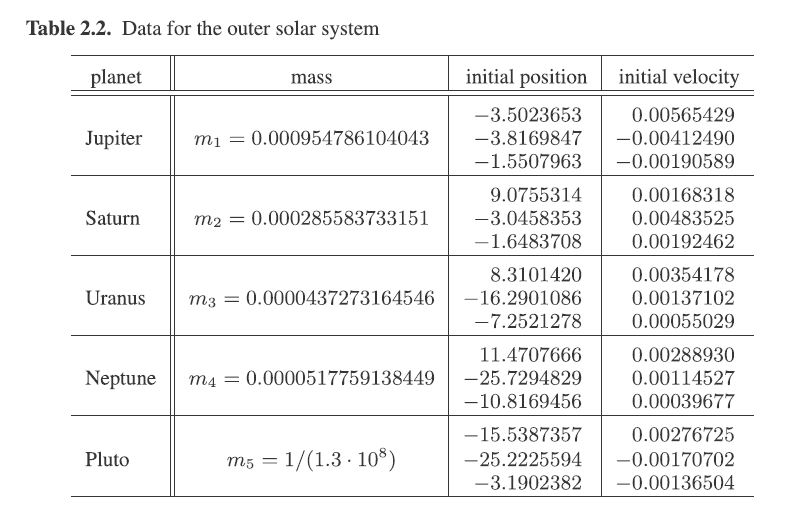

In [37]:
# structure : x = (q, p) = (q1,q2,...,qN, p1,p2,...,pN)
M = np.kron(np.diag(m_list),np.eye(dim))   # matrix M of dimension d containing the masses
M_inv = np.linalg.inv(M)

def norme(q,l): #Même longueur les deux, des tableaux numpy
    q=np.array(q)
    l=np.array(l)
    dist=np.sqrt( np.sum((q-l)**2))
    return(dist)
    
def U(q):  # q = (q1,q2,...,qN)
    u = 0
    for k in range(N):
        qk = q[dim*k:dim*(k+1)]
        for l in range(k):
            ql =q[dim*l:dim*(l+1)]
            u -= G*M[l,l]*M[k,k]/norme(qk,ql) 
    return u

def H(x):    # x = (q, p) = (q1,q2,...,qN, p1,p2,...,pN)
    q = x[0:N*dim]
    p = x[N*dim:]
    return 1/2*(p.transpose().dot(np.linalg.inv(M))).dot(p)+U(q)

def fq(p):   # p = (p1,p2,...,pN)
    final=np.zeros( (N*dim,))
    for k in range(N):
        final[k*dim:(k+1)*dim]=1/M[k,k]*p[k*dim:(k+1)*dim]
    return final

def fp(q):  # q = (q1,q2,...,qN) #Moi je les ai numérotés de 0 à N-1
    final=np.zeros((dim*N,))
    for k in range(N):
        pointpk=np.zeros((dim,))
        qk=q[dim*k:dim*(k+1)]
        #print(f"qk {qk.shape}")
        for l in range(N):
            #print(l)
            if l!=k:
                ql=q[dim*l:dim*(l+1)]
                #print(ql.shape)
                
                pointpk-=(qk-ql)/(norme(qk,ql))**3*G*M[k,k]*M[l,l]
    
        final[dim*k:dim*(k+1)]=pointpk
    return final


def f(x):
    q = x[:N*dim]
    p = x[N*dim:]
    return np.concatenate([fq(p),fp(q)])

# TEST example 1
#print(fp(np.array([0,0,2,3])))
#print(f(np.array([0,0,2,3,0,0,0,0])))

# TEST example 2
print(fp(np.array([0,0,0,2,3,4,-1,3,4,-1,3,6])))
print(fq(np.array([0,0,0,2,3,4,-1,3,4,-1,3,6])))
print(f(np.array([0,0,0,2,3,0,-1,3,5,-1,3,10,0,0,0,0,0,0,0,0,0,0,0,0])))

[ 1.55669036e-06  1.23834313e-05  1.65130530e-05 -3.66872778e-05
 -5.68450080e-06 -7.56727887e-06  3.51115985e-05 -6.69621373e-06
 -8.85765134e-06  1.89889011e-08 -2.71679003e-09 -8.81227547e-08]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.99998805e+00
  2.99998207e+00  3.99997609e+00 -9.99994023e-01  2.99998207e+00
  3.99997609e+00 -1.04735500e+03  3.14206500e+03  6.28413000e+03]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.11971457e-05  2.32278207e-05  7.14800472e-06 -1.71051111e-05
 -1.89397526e-05  7.46559034e-06  5.90697571e-06 -4.28733345e-06
 -1.45973620e-05  9.89719474e-10 -7.34689436e-10 -1.62330902e-08]


In [35]:
#Tests sur du broadcast
tab=np.zeros( (2,3,4) )
tab2=np.array([1,2,3]).reshape(3,1)
tab+tab2

array([[[1., 1., 1., 1.],
        [2., 2., 2., 2.],
        [3., 3., 3., 3.]],

       [[1., 1., 1., 1.],
        [2., 2., 2., 2.],
        [3., 3., 3., 3.]]])

Euler explicite
================

**Question 3** Compléter la fonction ci-dessous prenant en entrée une fonction $f: \mathbb{R}^n \to \mathbb{R}^n$ quelconque, une condition initiale $x_0$, un pas de temps $dt$, les temps initiaux et finaux, et renvoyant le vecteur des temps $t^j$ et de la solution $x^j$ du schéma d'Euler explicite appliqué à $\dot{x}=f(x)$. La tester sur une équation différentielle simple aux solutions exactes connues.

In [38]:
def solve_euler_explicit(f, x0, dt, t0, tf):
    ts, xs = [t0], [x0] #C'est une liste avec des listes dedans pour xs
    while ts[-1] < tf:
        xs.append(xs[-1] + dt*f(xs[-1]))
        ts.append(ts[-1]+dt)
    return (np.array(ts), np.array(xs).T) #On transpose pour mettre en colonne chaque instant.

def f2(x):
    return(x)
solve_euler_explicit(f2, np.exp(1), 0.0001, 1, 2) #Ok

(array([1.    , 1.0001, 1.0002, ..., 1.9999, 2.    , 2.0001]),
 array([2.71828183, 2.71855366, 2.71882551, ..., 7.38794789, 7.38868668,
        7.38942555]))

**Question 4** Utiliser le schéma d'Euler pour simuler les trajectoires des planètes. Visualiser l'évolution des positions $t\mapsto q(t)$ et du hamiltonien $H$. Ce schéma numérique vous semble-t-il adapté ? Que se passe-t-il lorsque $\Delta t$ tend vers 0 pour un horizon de temps $t_f$ donné ? Et à $\Delta t$ fixé, lorsque $t_f$ augmente ? Commenter.

<IPython.core.display.Javascript object>


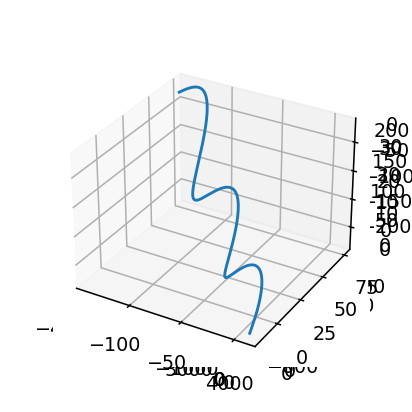

In [62]:
#On est en dim 3 ici
dt = 10
t_explicit, x_explicit = solve_euler_explicit(f, x0, dt, t0, tf)
fig=plt.figure()
axes=[fig.add_subplot(projection='3d') for k in range(N)]

for k in range(N):
    axes[k].plot(xs=x_explicit[k*dim,:],ys=x_explicit[k*dim+1,:], zs=x_explicit[k*dim+2,:], zdir='z')
    
#PAS FINI

Euler symplectique
==============

On cherche maintenant un schéma plus adapté. Pour cela, nous allons chercher un schéma, dit *symplectique*.

 
Notons d'abord qu'en définissant la matrice par blocs
$$
S = \left(
\begin{matrix}
0 & I_d \\
-I_d & 0
\end{matrix}
\right) \in \mathbb{R}^{2d\times 2d}
$$
la dynamique se réécrit
$$
\dot{x} = 
\left(
\begin{matrix}
f_q(p)\\
f_p(q)
\end{matrix}
\right)
= f(x) = S \ \nabla H(x) \ .
$$

**Question 4** Pour $d=1$, $x_a=(q_a,p_a)\in \mathbb{R}^2$ et $x_b=(q_b,p_b)\in \mathbb{R}^2$, justifier que $x_a^\top S x_b$ représente l'aire orientée du parallélogramme généré par $x_a$ et $x_b$.

On étend cette définition au cas $d>1$, où $x_a^\top S x_b$ avec $x_a,x_b\in \mathbb{R}^{2d}$ représente alors la somme des aires orientées des projections orthogonales sur chaque plan $(q_i,p_i)$ du parallélogrammes généré dans $\mathbb{R}^{2d}$ par $x_a,x_b$. Une transformation $C^1$ $\phi : \mathbb{R}^{2d}\to \mathbb{R}^{2d}$ est alors dite *symplectique*  si sa matrice jacobienne conserve l'aire, c'est-à-dire si
$$
J_\phi(x_a)^\top S J_\phi(x_b) = S \qquad \forall x_a,x_b\in \mathbb{R}^{2d}
$$



**Question 5 (Bonus)** Pour $t\in \mathbb{R}$, on définit le flot $\varphi_t : \mathbb{R}^{2d}\to \mathbb{R}^{2d}$ tel que $\varphi_t(x_0)$ donne la valeur au temps $t$ de la solution initialisée en $x_0$ à $t=0$. Montrer que pour un système hamiltonien, le flot est symplectique (Poincaré 1899). *Indice : montrer que $\frac{d}{dt} J_{\varphi_t}(x_a)^\top S J_{\varphi_t}(x_b)=0$.*

En d'autres termes, si l'on suit comment se déforme au cours du temps un ensemble de conditions initiales, on verra que l'ensemble se déforme mais conserve son aire. Le problème c'est que les schémas numériques usuels (dont les schémas d'Euler implicite et explicite) ne garantissent pas cette conservation. 

Considérons plutôt les schémas suivants, appelés *Euler Symplectiques*, qui ''mélangent'' les schémas d'Euler implicites et explicites :
$$
(A)
\left\{
\begin{array}{rcl}
q^{j+1} &=& q^{j} + \Delta t \, f_q(p^{j}) \\
p^{j+1} &=& p^{j} + \Delta t \, f_p(q^{j+1})
\end{array}
\right.
\qquad \text{ou} \qquad
(B)
\left\{
\begin{array}{rcl}
q^{j+1} &=& q^{j} + \Delta t \, f_q(p^{j+1}) \\
p^{j+1} &=& p^{j} + \Delta t \, f_p(q^{j})
\end{array}
\right.
$$

**Question 6** Justifier que ces schémas sont toujours consistant d'ordre 1. Réécrire un de ces schémas sous la forme $x^{j+1}=\Phi(x^j)$, pour $x^j=(q^j,p^j)$ et vérifier que $\Phi$ est symplectique à l'ordre 1 (en $\Delta t$). 

**Question 7** Coder ce schéma et le tester sur le système hamiltonien. Comment évolue $H$ maintenant ? Comparer aux conclusions tirées pour le schéma d'Euler explicite.

In [ ]:
def solve_euler_symplectic(fq,fp, x0, dt, t0, tf):
    ts, xs = [t0], [x0]
    while ts[-1] < tf:
        ...
    return (np.array(ts), np.array(xs).T)

In [ ]:
dt = ...
t_symplectic, x_symplectic = solve_euler_symplectic(fq,fp, x0, dt, t0, tf)


**Question 8 (BONUS)** On considère enfin la célèbre méthode de Störmer-Verlet
\begin{align*}
p^{j+1/2} &= p^{j} + \frac{\Delta t}{2} \, f_p(q^{j})\\
q^{j+1} &= q^{j} + \Delta t \,  f_q(p^{j+1/2}) \\
p^{j+1} &= p^{j+1/2} + \frac{\Delta t}{2} \, f_p(q^{j+1})
\end{align*}
construite à partir de la composition des deux schémas d'Euler symplectiques (A) et (B) ci-dessus. Justifier qu'elle est toujours symplectique mais qu'elle est maintenant d'ordre 2. Appliquer cette méthode au système hamiltonien et comparer les performances.

In [ ]:
def solve_euler_symplectic_SV(fq,fp, x0, dt, t0, tf):
    ts, xs = [t0], [x0]
    while ts[-1] < tf:
        ...
    return (np.array(ts), np.array(xs).T)

In [ ]:
t_symplectic_SV, x_symplectic_SV = solve_euler_symplectic_SV(fq,fp, x0, dt, t0, tf)
